In [13]:
import requests
import time

# Function to fetch citation data for a given paper ID with retries
def fetch_citations(paper_id, max_retries=3):
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=title,citations.paperId,citations.title"
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)  # Set timeout to avoid hanging requests
            
            if response.status_code == 200:
                return response.json()
            elif response.status_code == 429:  # Rate limit exceeded
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"Rate limit hit. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"Error {response.status_code} for {paper_id}: {response.text}")
                return None

        except requests.exceptions.RequestException as e:
            print(f"Request failed (Attempt {attempt+1}/{max_retries}): {e}")
            time.sleep(2)  # Small delay before retrying

    print(f"Failed to fetch data for {paper_id} after {max_retries} attempts.")
    return None

# Root paper IDs
root_paper_ids = [
    "f7b7b397072e66d7e8f515cb5a97d6c4bfd953ba",  # Paper 1
    "ec85c5c98674d3c04c345ab420638687f9fdaab8"   # Paper 2
]

# Data storage for each paper
citation_data = {}

# Fetch citation data for each paper
for root_paper_id in root_paper_ids:
    citation_dict = {}   # Stores paper ID → Title mapping
    citation_edges = []  # Stores [cited_paper_id, citing_paper_id] relationships
    id_arr = [root_paper_id]  # Queue for BFS-like processing

    # Set a time limit (3 minutes = 180 seconds)
    start_time = time.time()

    while id_arr:
        elapsed_time = time.time() - start_time
        if elapsed_time > 180:  
            print(f"Time limit exceeded for {root_paper_id}. Stopping collection.")
            break
        
        paper_id = id_arr.pop(0)  
        data = fetch_citations(paper_id)

        if data:
            paper_title = data.get("title", "Unknown Paper")
            citation_dict[paper_id] = paper_title  

            print(f"\nCiting Papers for: {paper_title} (ID: {paper_id})")

            for citation in data.get("citations", []):
                cited_paper_id = citation.get("paperId")
                cited_paper_title = citation.get("title", "Unknown Title")

                if cited_paper_id and cited_paper_title and paper_id:
                    if cited_paper_id not in citation_dict:
                        citation_dict[cited_paper_id] = cited_paper_title
                        id_arr.append(cited_paper_id)  

                    citation_edges.append([cited_paper_id, paper_id])  

                    print(f"{cited_paper_title} (ID: {cited_paper_id})")
        
        time.sleep(1)  # Prevent excessive API calls

    citation_data[root_paper_id] = {"dict": citation_dict, "edges": citation_edges}

print("\nFinished fetching citations for all papers.")



Citing Papers for: Groundwater quality assessment for agricultural purposes at Vellore District of Southern India: A geospatial based study (ID: f7b7b397072e66d7e8f515cb5a97d6c4bfd953ba)
Chromium contamination in water: a comparative analysis of detection methods with a focus on portability (ID: 81c70b4d76bc38133c60bd496b28bdb9054dec88)
Metagenomic Profiling of Soil Microbial Communities in Chromium-Contaminated Tannery Sludge (ID: 189b137cd711f9a930489bdd24ed335492b34b1d)
Hydrogeochemistry and its relationship with land use pattern and monsoon in hard rock aquifer (ID: c5f7e0d33835cd2ee1dd15c13936eb53a854cfe1)
Groundwater quality assessment in selected polluted hotspots of Tamil Nadu, India using geospatial and statistical approaches (ID: e418ed7f7ad1bc2e42552c8e4029bd33ac708357)
Remediation of Cr(VI) Polluted Groundwater Using Zero-Valent Iron Composites: Preparation, Modification, Mechanisms, and Environmental Implications (ID: 321d9c3c7b690cb3d07a19876b790c38d5b9905e)
Groundwater 

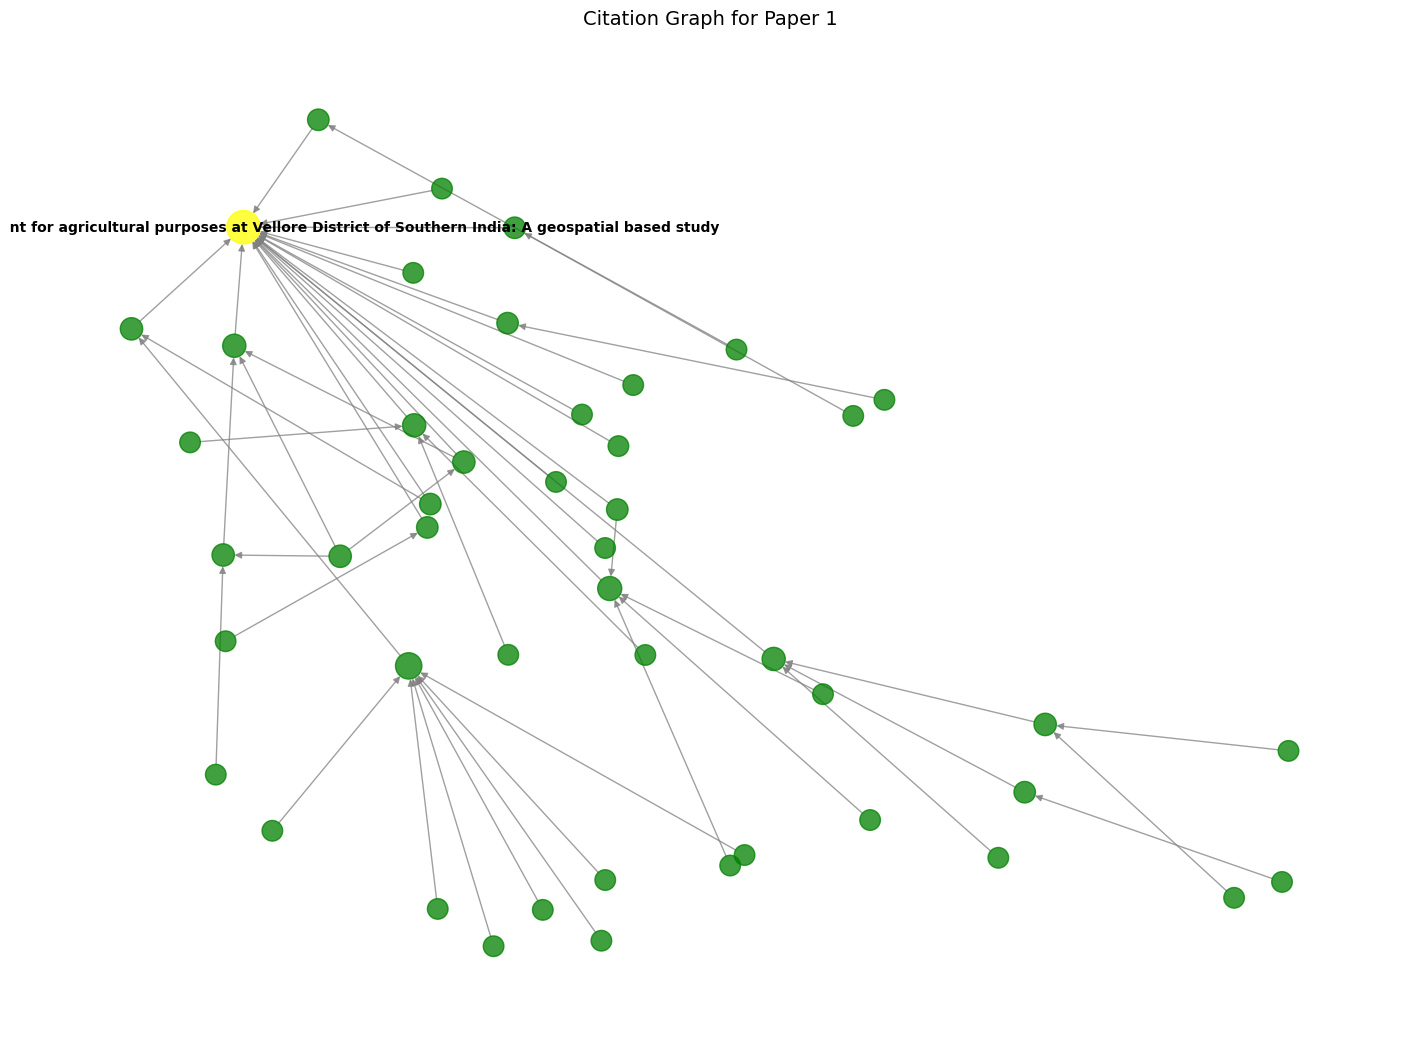

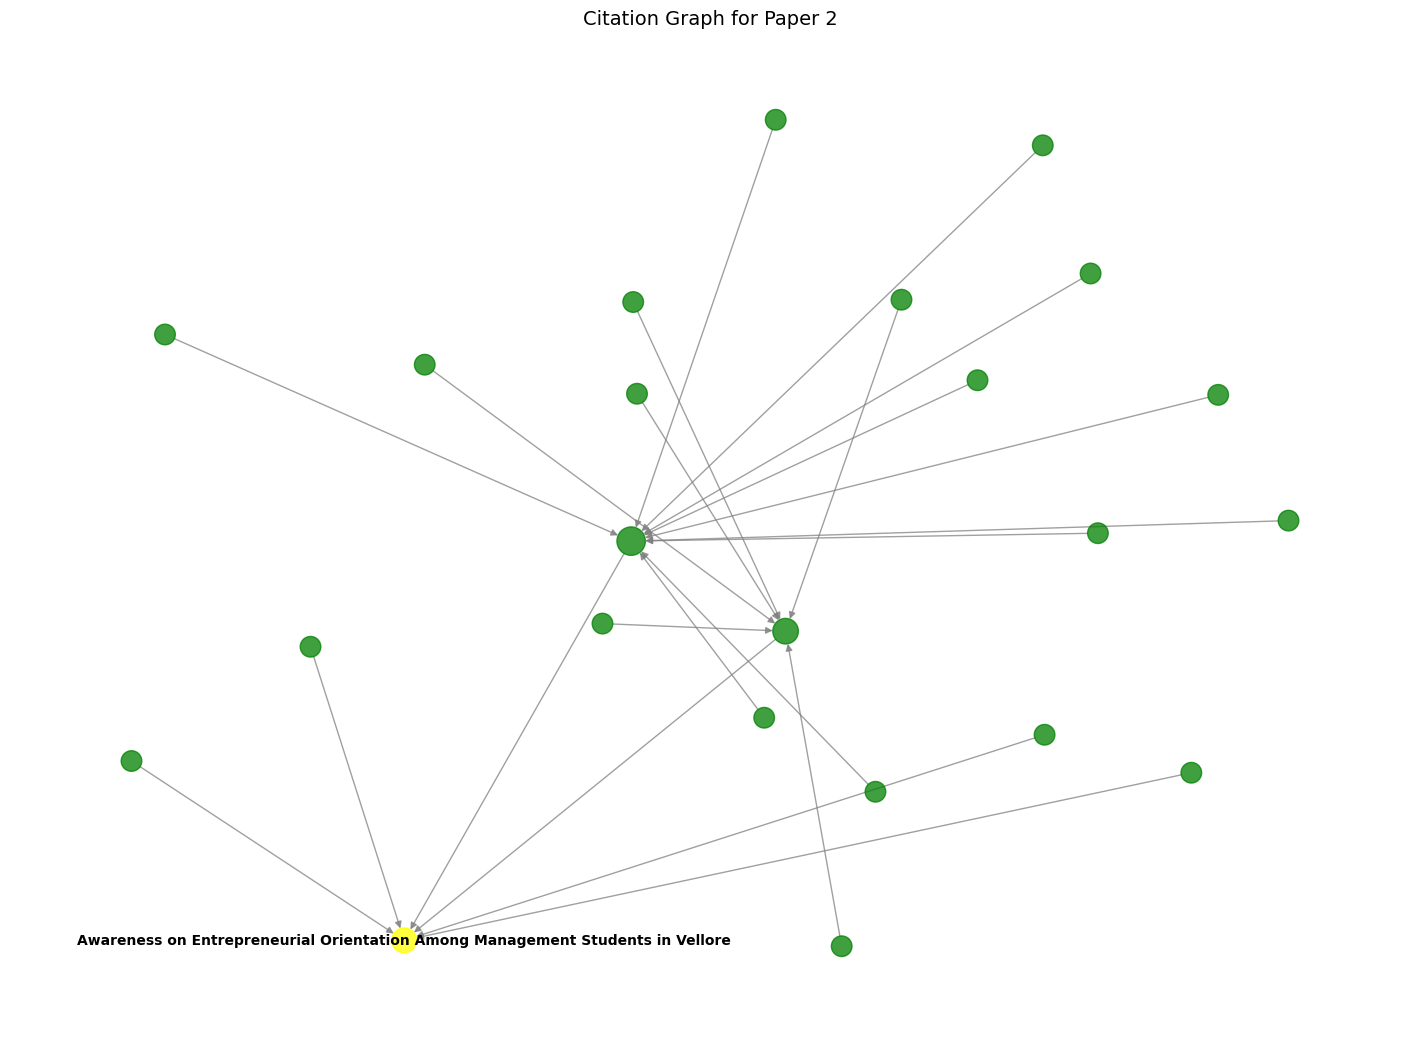

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to visualize the full citation graph
def draw_graph(root_paper_id, citation_edges, citation_dict, paper_num):
    G = nx.DiGraph()
    G.add_edges_from(citation_edges)

    # Ensure all papers (including isolated ones) are added
    for node in citation_dict.keys():
        if node not in G:
            G.add_node(node)

    pos = nx.spring_layout(G)

    node_colors = ["yellow" if node == root_paper_id else "green" for node in G.nodes()]

    # Smaller node sizes (previously 500 + 50 * degree)
    node_sizes = [200 + 20 * G.degree(node) for node in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw(G, pos, with_labels=False, node_size=node_sizes, 
            node_color=node_colors, edge_color="gray", 
            font_size=6, arrows=True, alpha=0.75)

    # Label only the main (root) paper
    if root_paper_id in pos:
        nx.draw_networkx_labels(G, pos, labels={root_paper_id: citation_dict.get(root_paper_id, "Main Paper")},
                                font_size=10, font_color="black", font_weight="bold")

    plt.title(f"Citation Graph for Paper {paper_num}", fontsize=14)
    plt.show()

    return G

# Generate and visualize graphs separately for each paper
graphs = {}
for idx, root_paper_id in enumerate(root_paper_ids):
    citation_edges = citation_data[root_paper_id]["edges"]
    citation_dict = citation_data[root_paper_id]["dict"]
    graphs[root_paper_id] = draw_graph(root_paper_id, citation_edges, citation_dict, idx + 1)


In [19]:
# Function to compute network measures
def compute_measures(G, paper_num):
    print(f"\n Network Measures for Paper {paper_num}")

    # Compute Diameter
    if nx.is_strongly_connected(G):
        diameter = nx.diameter(G)
        print(f"Graph Diameter: {diameter}")
    else:
        print("Graph is not strongly connected. Diameter cannot be computed.")
        sccs = list(nx.strongly_connected_components(G))
        largest_scc = max(sccs, key=len)
        G_scc = G.subgraph(largest_scc)
        diameter_scc = nx.diameter(G_scc)
        print(f"Diameter of the Largest Strongly Connected Component: {diameter_scc}")

    # Centrality Measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    pagerank = nx.pagerank(G)

    print("\nTop 5 Nodes by Degree Centrality:")
    print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

    print("\nTop 5 Nodes by Closeness Centrality:")
    print(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

    print("\nTop 5 Nodes by Betweenness Centrality:")
    print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

    print("\nTop 5 Nodes by Eigenvector Centrality:")
    print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

    print("\nTop 5 Nodes by PageRank:")
    print(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

    # HITS Algorithm
    hubs, authorities = nx.hits(G)
    print("\nTop 5 Nodes by Hub Score:")
    print(sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:5])

    print("\nTop 5 Nodes by Authority Score:")
    print(sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:5])

    # Clustering Coefficients
    global_clustering = nx.average_clustering(G)
    local_clustering = nx.clustering(G)

    print(f"\nGlobal Clustering Coefficient: {global_clustering}")

    print("\nTop 5 Nodes by Local Clustering Coefficient:")
    print(sorted(local_clustering.items(), key=lambda x: x[1], reverse=True)[:5])

    # Connected Components
    if nx.is_directed(G):
        weakly_connected_components = list(nx.weakly_connected_components(G))
        print(f"\nNumber of Weakly Connected Components: {len(weakly_connected_components)}")
    else:
        connected_components = list(nx.connected_components(G))
        print(f"\nNumber of Connected Components: {len(connected_components)}")

# Compute network measures for each graph
for idx, root_paper_id in enumerate(root_paper_ids):
    compute_measures(graphs[root_paper_id], idx + 1)


 Network Measures for Paper 1
Graph is not strongly connected. Diameter cannot be computed.
Diameter of the Largest Strongly Connected Component: 0

Top 5 Nodes by Degree Centrality:
[('f7b7b397072e66d7e8f515cb5a97d6c4bfd953ba', 0.41304347826086957), ('1883cc3b41a1b0e656bdf8757a947cbfefc42867', 0.17391304347826086), ('8c4b60296ebea60729396e6772169c193ab98cba', 0.10869565217391304), ('e0623f2e286cbb6eaa28e40e6ba448c05afdb551', 0.08695652173913043), ('767189c38e52618963966883598cca9dd296b8af', 0.08695652173913043)]

Top 5 Nodes by Closeness Centrality:
[('f7b7b397072e66d7e8f515cb5a97d6c4bfd953ba', 0.5476190476190477), ('1883cc3b41a1b0e656bdf8757a947cbfefc42867', 0.15217391304347827), ('da95a94f8702c6fc1aeb170a561e465b244de452', 0.11005434782608696), ('9cc9702aa3e5f53ed48ab6f676334d963147ffec', 0.08695652173913043), ('8c4b60296ebea60729396e6772169c193ab98cba', 0.08695652173913043)]

Top 5 Nodes by Betweenness Centrality:
[('1883cc3b41a1b0e656bdf8757a947cbfefc42867', 0.006763285024154589)